In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
%matplotlib inline

In [2]:
def FFT_quick(data,dt):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(data), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

In [3]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [4]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MIvalue=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])/dt
        MIvalue[i]=np.sum(MIsingle)
    return timeshift,MIvalue

In [5]:
# white noise 
# dt=0.01
# T=np.arange(dt,100,dt)
# mu, sigma = 0, 1
# x=np.random.normal(mu, sigma,len(T))
# plt.plot(T,x)
# plt.xlim()
# plt.show()

# freq,p1,phase1=FFT_quick(x,dt)
# plt.plot(freq,p1)

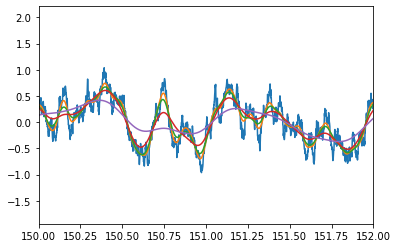

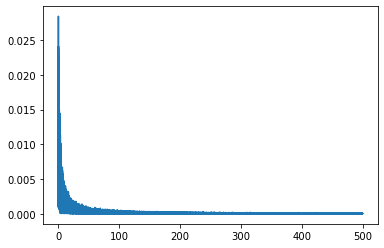

In [6]:
# generate OU
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
tau=0.1
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering
fc=[10,7,4,2]
x_set=[L]
for ifc in range(len(fc)):
    b, a = signal.butter(2, 2*fc[ifc]*dt, btype='low', analog=False)
    Lf = signal.filtfilt(b, a, L)
    x_set.append(Lf)
    
for i in range(np.size(x_set,0)):
    plt.plot(T,x_set[i])
plt.xlim(150,152)
plt.show()

freq,p1,phase1=FFT_quick(x_set[0],dt)
plt.plot(freq,p1)

x=x_set[-1]

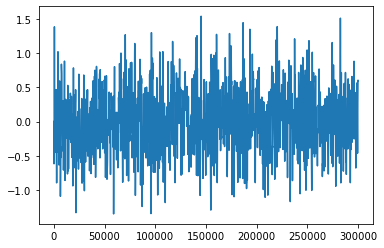

(-24.999749999166664, 524.9947499824999)

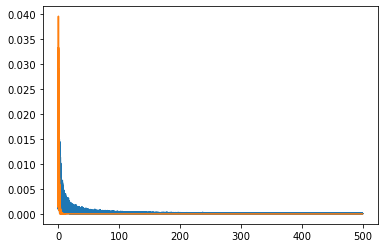

In [7]:
# low pass
beta, g =50,70
y=np.zeros(len(x))
for i in range(len(x)-1):
    dy=dt*(-beta*y[i]+g*x[i])
    y[i+1]=y[i]+dy
    
plt.plot(y)
plt.show()
freq,p2,phase2=FFT_quick(y,dt)
plt.plot(freq,p1)
plt.plot(freq,p2)
plt.xlim()

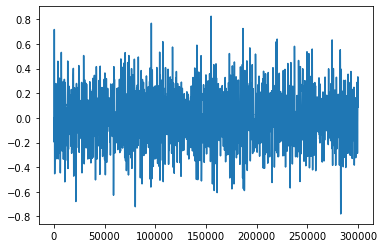

(0.0, 5.0)

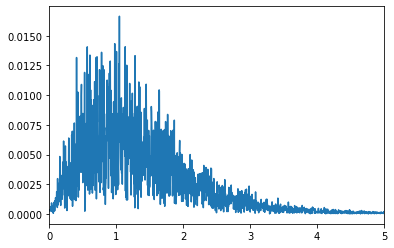

In [8]:
# high pass
v=np.diff(x)/dt
xhigh=np.zeros(len(v))
for i in range(len(v)-1):
    dxhigh=dt*(-xhigh[i]/0.2+v[i])
    xhigh[i+1]=xhigh[i]+dxhigh
plt.plot(xhigh)
plt.show()
freq,p3,phase3=FFT_quick(xhigh,dt)
plt.plot(freq,p3)
plt.xlim(0,5)

In [18]:
# z=np.zeros(len(x))
# for i in range(len(x)-1):
#     dy=dt/0.02*(-y[i]+x[i])
#     dz=dt*(-z[i]/0.03)+dy
#     z[i+1]=z[i]+dz

# plt.plot(z)
# plt.show()
# freq,p2,phase2=FFT_quick(z,dt)
# plt.plot(freq,p1)
# plt.plot(freq,p2)
# plt.xlim()

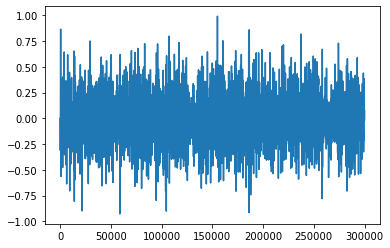

(0.0, 5.0)

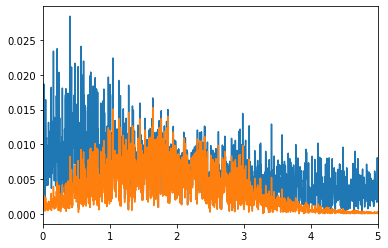

In [10]:
# NGD model
alpha, beta, K, g =8,1.4,37,10
y=np.zeros(len(T))
temp=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz
    
plt.plot(y)
plt.show()
freq,p2,phase2=FFT_quick(y,dt)
plt.plot(freq,p1)
plt.plot(freq,p2)
plt.xlim(0,5)

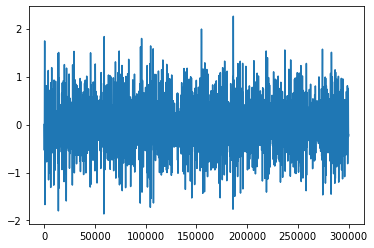

(0.0, 5.0)

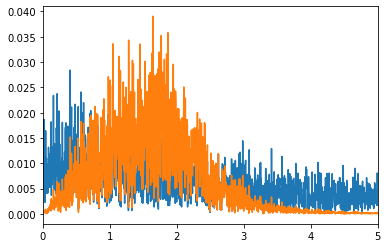

In [19]:
# feedback with a high pass filter
alpha, beta, K, g =8,1.4,37,10
y=np.zeros(len(T))
temp=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dtemp=dt*(-beta*temp[j]+g*y[j])
    dz=dt*(-z[i]/1)+0.5*dtemp
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz
plt.plot(y)
plt.show()
freq,p2,phase2=FFT_quick(y,dt)
plt.plot(freq,p1)
plt.plot(freq,p2)
plt.xlim(0,5)

In [12]:
def NGD(x):
    alpha, beta, K, g =8,1.4,37,10
    y=np.zeros(len(T))
    temp=np.zeros(len(T))
    z=np.zeros(len(T))
    for j in range(len(T)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [13]:
def NGD_band(x):
    alpha, beta, K, g =8,1.4,37,10
    y=np.zeros(len(T))
    yhp=np.zeros(len(T))
    z=np.zeros(len(T))
    dy=0
    for j in range(len(T)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        dyhp=dt*(-yhp[i]/20)+dy
#         dyhp=dt*(-z[j]/1000+y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        yhp[j+1]=yhp[j]+dyhp
    return y,yhp,z

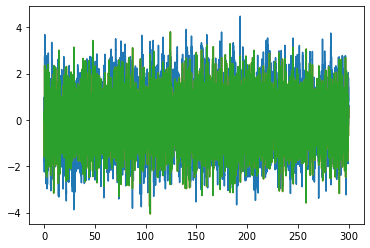

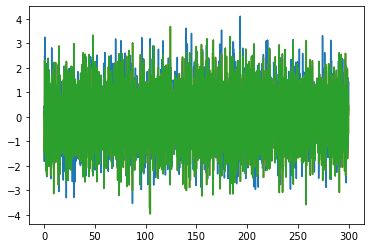

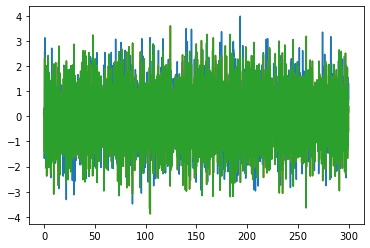

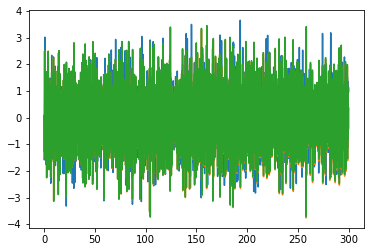

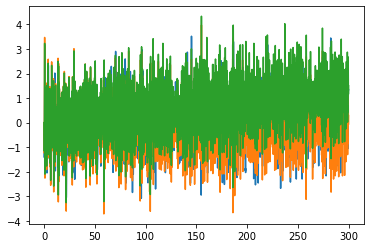

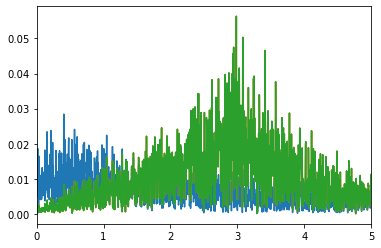

In [14]:
y_set=[[] for i in range(len(x))]
yhp_set=[[] for i in range(len(x))]
z_set=[[] for i in range(len(x))]
for i in range(len(x_set)):
    y_set[i],yhp_set[i],z_set[i]=NGD_band(x_set[i])
    plt.plot(T,x_set[i]/np.std(x_set[i]))
    plt.plot(T,y_set[i]/np.std(y_set[i]))
    plt.plot(T,yhp_set[i]/np.std(yhp_set[i]))
    plt.xlim()
    plt.show()
    
freq,p2,phase2=FFT_quick(y_set[2],dt)
freq,p3,phase3=FFT_quick(yhp_set[2],dt)
plt.plot(freq,p1)
plt.plot(freq,p2)
plt.plot(freq,p3)
plt.xlim(0,5)
    
MI_set=[[] for i in range(len(x_set))]
for i in range(len(x_set)):
    timeshift,MI_set[i]=MI(EqualState(x_set[i],8),EqualState(yhp_set[i],8),dt,[-1,1])

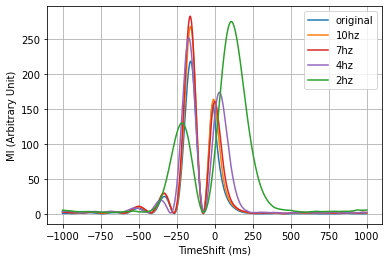

In [15]:
for i in range(np.size(x_set,0)):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    plt.plot(timeshift*1000,MI_set[i],color=colorlist[i]) 
    legend_list=[str(fc[j])+'hz' for j in range(len(fc))]
    legend_list.insert(0,'original')
#     plt.legend(('original','10hz','7hz','4hz','2hz'))
    plt.legend((legend_list))
    plt.xlabel('TimeShift (ms)')
    plt.ylabel('MI (Arbitrary Unit)')
plt.grid()
plt.show()
#     plt.xlim(-500,500)

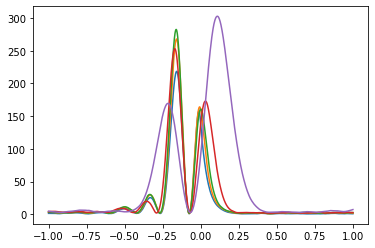

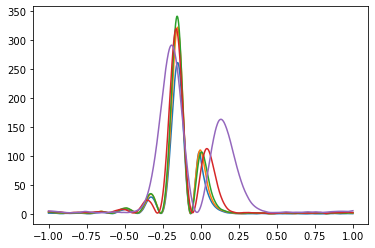

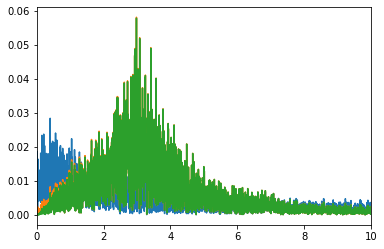

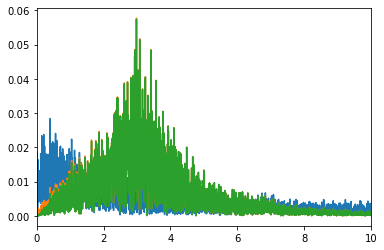

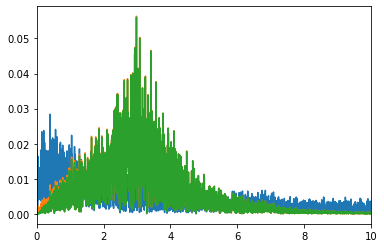

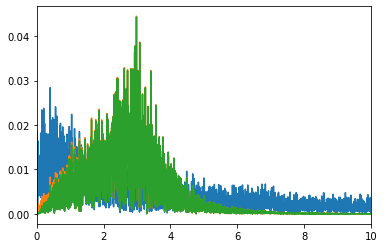

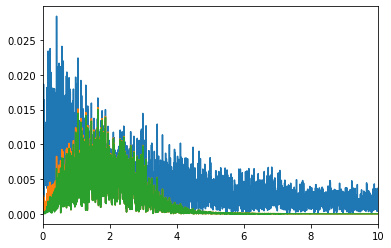

In [16]:
fig1,ax1=plt.subplots(figsize=(6,4))
fig2,ax2=plt.subplots(figsize=(6,4))
# fig_fft1,axfft1=plt.subplots(figsize=(6,4))
for n in range(len(x_set)):
    y1,yhp1,z1=NGD_band(x_set[n])
    vy=np.diff(y1)
    yout=np.zeros(len(y1))
    for i in range(len(vy)-1):
        dyout=-dt*(yout[i]/0.5)+vy[i]
        yout[i+1]=yout[i]+dyout
#     plt.plot(T,y1/np.std(y1))
#     plt.plot(T,yout/np.std(yout))
#     plt.xlim(120,130)
#     plt.show()

    freq,p2,phase2=FFT_quick(y1,dt)
    freq,p3,phase3=FFT_quick(yout,dt)
    plt.figure()
    plt.plot(freq,p1)
    plt.plot(freq,p2)
    plt.plot(freq,p3)
    plt.xlim(0,10)

    timeshift,MI1=MI(EqualState(x_set[n],8),EqualState(y1,8),dt,[-1,1])
    timeshift,MIhp=MI(EqualState(x_set[n],8),EqualState(yout,8),dt,[-1,1])
    ax1.plot(timeshift,MI1)
    ax2.plot(timeshift,MIhp)

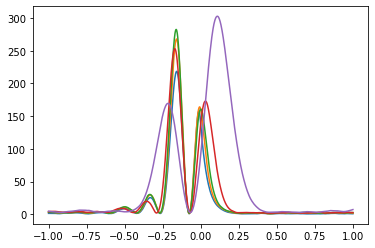

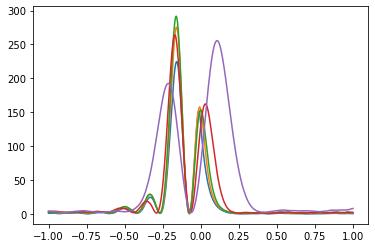

In [17]:
fc_out=0.3
fig1,ax1=plt.subplots(figsize=(6,4))
fig2,ax2=plt.subplots(figsize=(6,4))
for n in range(len(x_set)):
    y1,yhp1,z1=NGD_band(x_set[n])

    b, a = signal.butter(2, 2*fc_out*dt, btype='high', analog=False)
    y1hp = signal.filtfilt(b, a, y1)
    timeshift,MI1=MI(EqualState(x_set[n],8),EqualState(y1,8),dt,[-1,1])
    timeshift,MIhp=MI(EqualState(x_set[n],8),EqualState(y1hp,8),dt,[-1,1])
    ax1.plot(timeshift,MI1)
    ax2.plot(timeshift,MIhp)